In [1]:
import numpy as np
from matplotlib import pyplot as plt

from my_utils import *
from laplace2D import *

import copy

In [2]:
my_grid = grid(-0.7e-3,0.7e-3,5e-6,-0.1e-3,0.5e-3,5e-6)


plane = conductor(-1e-3  , 1e-3  , -50e-6, 0     , V=-0.5)
trace = conductor(-100e-6, 100e-6, 140e-6, 160e-6, V=+0.5)

V = trace.V - plane.V

FR4   = dielectric(-1e-3,1e-3,-20e-6,150e-6,eps_r=3.5)

conductor_list  = [trace,plane]
dielectric_list = [FR4]

step n=3 done


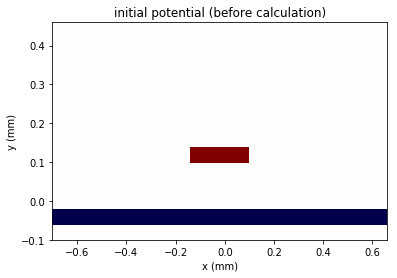

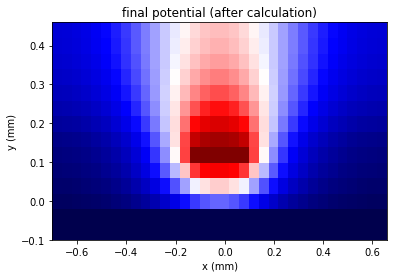

step n=2 done


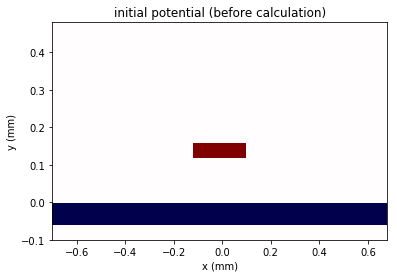

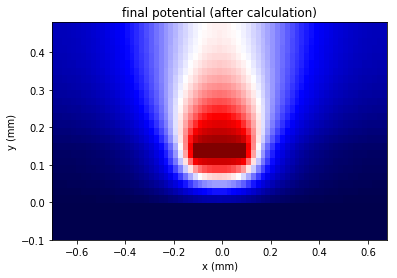

step n=1 done


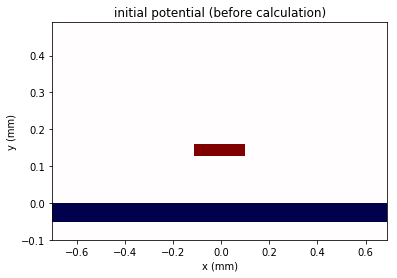

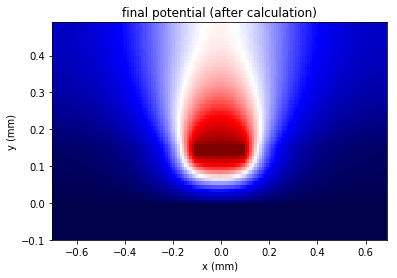

step n=0 done


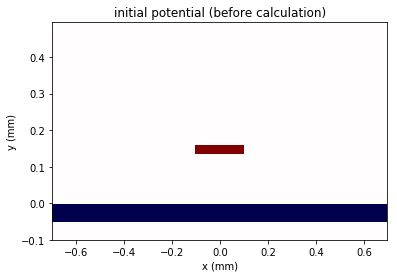

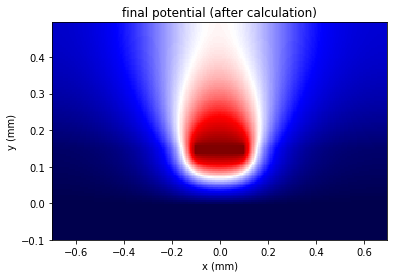

In [13]:
conductor_mask  = None
start_potential = None
epsilon         = None
potential       = None

iterations = 2000

stepping_levels = 4

levels = list(range(stepping_levels))
levels.reverse()

for n in levels:
    temp_grid = quarter_grid(my_grid,n=n)

    conductor_mask, start_potential = conductors_to_mask(temp_grid,conductor_list)
    epsilon                         = gen_dielectric_field(temp_grid,dielectric_list)
        
    if potential is None:
        potential                       = copy.deepcopy(start_potential)
    else:
        upscaled_matrix = up4scale(potential.matrix) # upscale matrix from previous step
        potential  = copy.deepcopy(start_potential)
        si,sj = potential.matrix.shape
        potential.matrix[0:si,0:sj] = upscaled_matrix[0:si,0:sj] 
        
        # update the precise shapes of the conductors
        potential.matrix = potential.matrix * (1-conductor_mask.matrix) \
                            + start_potential.matrix*(conductor_mask.matrix)
        
        

    #for i in range(int(iterations/(2**n))):
    for i in range(int(iterations)):
        relax_2D_dielectric(potential,conductor_mask,epsilon)
        
        
    print("step n={} done".format(n))
    scale= 0.5
    small_figure()
    plt.pcolormesh(temp_grid.X*1e3,temp_grid.Y*1e3,start_potential.matrix,cmap="seismic")
    plt.clim(-scale,scale)
    plt.title("initial potential (before calculation)")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.show()

    plt.pcolormesh(temp_grid.X*1e3,temp_grid.Y*1e3,potential.matrix,cmap="seismic")
    plt.clim(-scale,scale)
    plt.title("final potential (after calculation)")
    plt.xlabel("x (mm)")
    plt.ylabel("y (mm)")
    plt.show()

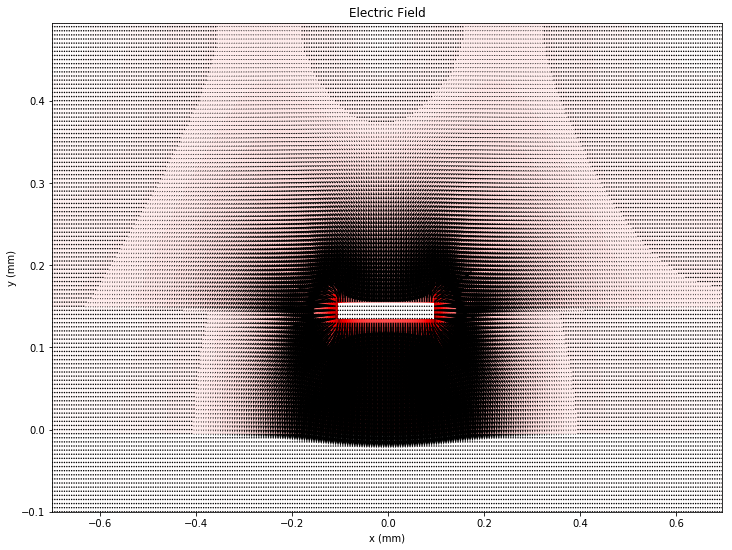

In [6]:
E = E_from_V(potential)

big_figure()

E_abs = E.abs_matrix()

scale = np.max(E_abs)

plt.pcolormesh(my_grid.X*1e3,my_grid.Y*1e3,E_abs, cmap='seismic')
plt.clim(-scale,scale)
plt.quiver(my_grid.X*1e3,my_grid.Y*1e3,E.matrix[:,:,0],E.matrix[:,:,1], scale=3e5)

plt.title("Electric Field")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.show()

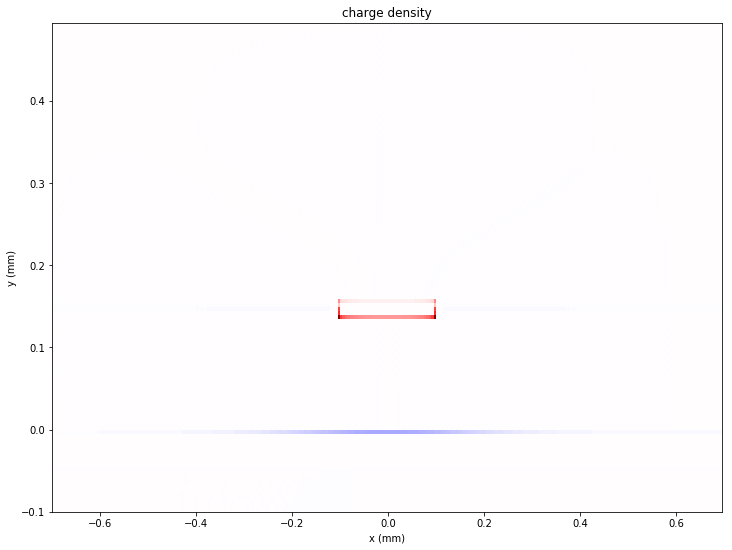

In [7]:
rho = rho_from_V(potential,epsilon)

scale = np.max(np.abs(rho.matrix))

plt.pcolormesh(my_grid.X*1e3,my_grid.Y*1e3,rho.matrix,cmap="seismic")
plt.clim(-scale,scale)
plt.title("charge density")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.show()

In [8]:
##################################################
##  normalizing rho to get the current density  ##
##################################################

Q1 = charge_on_conductor(rho,trace)

J = field(rho.grid)

J.matrix = rho.matrix/(Q1/my_grid.area_element)

B = B_of_conductors(J,conductor_list)

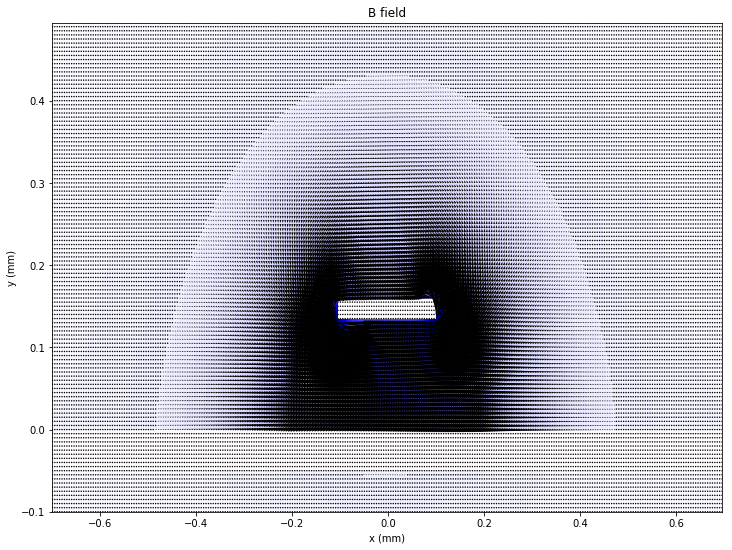

In [9]:
B_abs = B.abs_matrix()

scale = np.max(B_abs)

cmap="seismic"

scale = 8e-3


plt.pcolormesh(my_grid.X*1e3,my_grid.Y*1e3,-B_abs, cmap=cmap)
plt.clim(-scale,scale)
plt.quiver(my_grid.X*1e3,my_grid.Y*1e3,B.matrix[:,:,0],B.matrix[:,:,1], scale=.1)
plt.title("B field")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.show()


In [10]:
phi = flux_between_conductors(B,trace,plane)

I = 1

L = phi/I

C = Q1/V

Z = np.sqrt(abs(L/C))

print("C' = {:3.3f} pF/m".format(C*1e12))
print("L' = {:3.3f} uH/m".format(L*1e6))
print("Z  = {:3.3f} R".format(Z))


C' = 89.184 pF/m
L' = 0.356 uH/m
Z  = 63.205 R


In [11]:
V

1.0

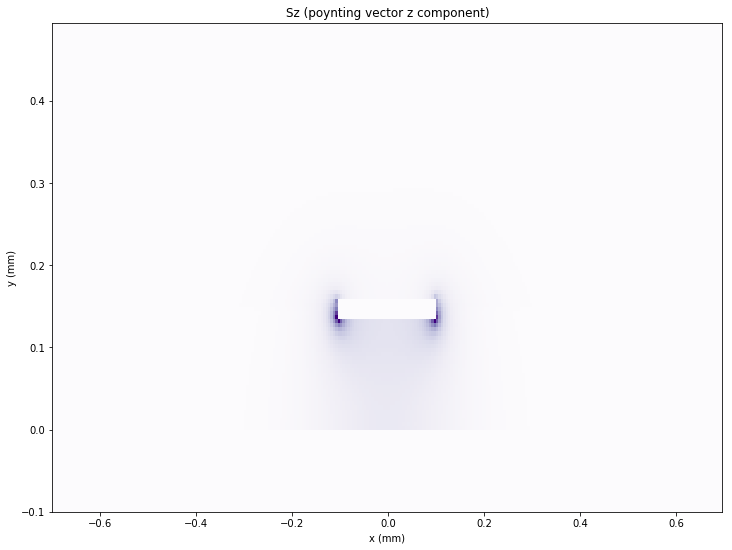

In [12]:
Sz = poynting_z(E,B)


cmap="Purples"

scale = np.max(Sz.matrix)*0.8


plt.pcolormesh(my_grid.X*1e3,my_grid.Y*1e3,Sz.matrix, cmap=cmap)
plt.clim(0,scale)
plt.title("Sz (poynting vector z component)")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.show()